In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd

import cvxportfolio as cp
%run ../../Personal-Investing/bin/data

In [4]:
bbg = BBG()

Download the problem data from Bloomberg. We select four liquid stocks, and the risk-free rate.

In [33]:
bbgData = BbgData()
_=bbgData.db(database='../../Personal-Investing/data/bloomberg.sqlite3')
futuresData = FuturesData()
_=futuresData.db(database='../../Personal-Investing/data/bloomberg.sqlite3')

In [78]:
tickers = ['ES Index', 'TY Comdty', 'CO Comdty', 'GX Index', 'RX Comdty']
start_date='20000101'
end_date='20161231'
returns = futuresData.offline.PX_LAST.xs(1,1,1)[tickers].diff()/futuresData.offline.PX_LAST_UNADJ.xs(1,1,1)[tickers].shift()
returns = returns.loc[start_date:end_date]

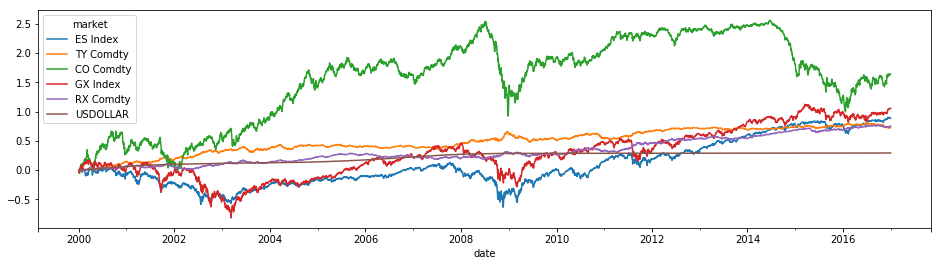

In [79]:
returns['USDOLLAR'] = bbg.getBbgHistData(['USGG3M Index'], field='PX_LAST', start=start_date,end=end_date)/250/100
#returns = returns.drop('USGG3M Index',1)
returns = returns.fillna(method='ffill').iloc[1:]

returns.cumsum().plot(figsize=(16,4))

We compute rolling estimates of the first and second moments of the returns using a window of 250 days. We shift them by one unit (so at every day we present the optimizer with only past data).

In [80]:
r_hat = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
Sigma_hat = returns.rolling(window=250, min_periods=250, closed='neither').cov().dropna()

r_hat.head()

market,ES Index,TY Comdty,CO Comdty,GX Index,RX Comdty,USDOLLAR
date,,,,,,
2000-12-20,-0.000344,0.000520,0.001363,0.000140,0.000241,0.00024
2000-12-21,-0.000466,0.000568,0.001147,0.000047,0.000259,0.00024
2000-12-22,-0.000412,0.000565,0.001277,0.000037,0.000255,0.00024
2000-12-25,-0.000451,0.000556,0.001375,-0.000127,0.000228,0.00024
2000-12-26,-0.000372,0.000572,0.001273,-0.000168,0.000230,0.00024


Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

In [81]:
tcost_model=cp.TcostModel(half_spread=10E-4, nonlin_coeff=1.)
hcost_model=cp.HcostModel(borrow_costs=1E-4)

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [82]:
risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5., 1., 1.
leverage_limit = cp.LeverageLimit(3)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
                                constraints=[leverage_limit])

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [83]:
market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
init_portfolio = pd.Series(index=returns.columns, data=250000.)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time='2001-01-12',  end_time='2016-12-31',  
                               policies=[spo_policy, cp.Hold()])
results[0].summary()

Number of periods                              4166
Initial timestamp               2001-01-12 00:00:00
Final timestamp                 2016-12-30 00:00:00
Portfolio return (%)                          7.175
Excess return (%)                             5.790
Excess risk (%)                              16.143
Sharpe ratio                                  0.359
Max. drawdown                                36.822
Turnover (%)                                100.504
Average policy time (sec)                     0.098
Average simulator time (sec)                  0.003


The total value of the portfolio in time.

Hold    0.239166
SPO     0.337726
dtype: float64

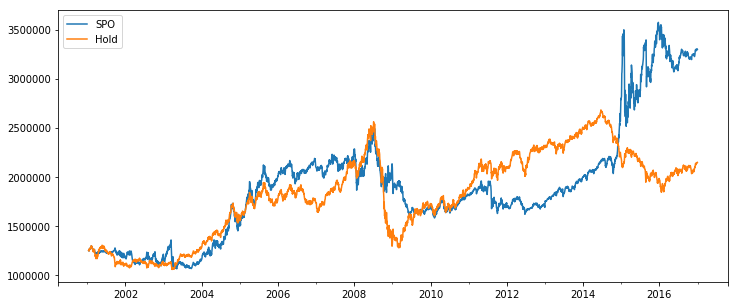

In [90]:
results[0].v.plot(figsize=(12,5), label='SPO')
ax=results[1].v.plot(figsize=(12,5), label='Hold')
ax.legend(loc=0)
res=pd.concat({
    'SPO':results[0].v,
    'Hold':results[1].v,
},1).diff()
res.mean()/res.std() * np.sqrt(252)

The weights vector of the portfolio in time.

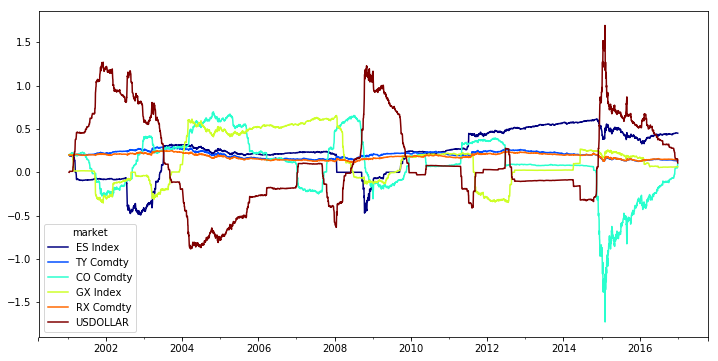

In [85]:
results[0].w.plot(figsize=(12,6),cmap='jet')

In [94]:
results[0].sharpe_ratio

0.3587132108450533